In this notebook we want to try to use a Neural Network to predict the correct party

In [228]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import keras.backend as K
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
# exclude everything we dont need for faster performance
nlp = spacy.load("de_core_news_lg", exclude=['tagger', 'morphologizer', 'parser', 'senter', 'ner', 'attribute_ruler', 'lemmatizer'])

## Reading cleand data
The following Block creates a data Frame in which each tweets is labeled with its corresponding party.

In [6]:
data = pd.DataFrame(columns=['tweet', 'party'])

afd = pd.read_csv('../cleaned-data/AfD.csv')['text']
afd = pd.DataFrame([[i, 0] for i in afd], columns=['tweet', 'party'])

data = data.append(afd, ignore_index=True)

cdu = pd.read_csv('../cleaned-data/CDU.csv')['text']
csu = pd.read_csv('../cleaned-data/CSU.csv')['text']

cdu = pd.DataFrame([[i, 1] for i in cdu], columns=['tweet', 'party'])
csu = pd.DataFrame([[i, 1] for i in csu], columns=['tweet', 'party'])

data = data.append(cdu, ignore_index=True)
data = data.append(csu, ignore_index=True)

fdp = pd.read_csv('../cleaned-data/FDP.csv')['text']
fdp = pd.DataFrame([[i, 2] for i in fdp], columns=['tweet', 'party'])

data = data.append(fdp, ignore_index=True)

gru = pd.read_csv('../cleaned-data/GRÜNE.csv')['text']
gru = pd.DataFrame([[i, 3] for i in gru], columns=['tweet', 'party'])

data = data.append(gru, ignore_index=True)

lin = pd.read_csv('../cleaned-data/LINKE.csv')['text']
lin = pd.DataFrame([[i, 4] for i in lin], columns=['tweet', 'party'])

data = data.append(lin, ignore_index=True)

spd = pd.read_csv('../cleaned-data/SPD.csv')['text']
spd = pd.DataFrame([[i, 5] for i in spd], columns=['tweet', 'party'])

data = data.append(spd, ignore_index=True)

# Removing NaN. Those were probably tweets with only a link or emojis with dont include anything after cleaning
data = data.dropna()

## Transforming tweets to vectors
For this step we are using the pre-trained de_core_news_lg spacy model.

In [5]:
X = [nlp(tweet).vector for tweet in tqdm(data['tweet'].to_numpy())]
# We will save the vectors to a file sice its faster to read them in if we want to use them somewhere else.
# The file is ~2.2GB
np.savetxt('vector_tweets.out', X, delimiter=',')

100%|█████████████████████████████████| 304283/304283 [07:58<00:00, 635.32it/s]


In [27]:
# load the vector representation (300d)
X = np.loadtxt('vector_tweets.out', delimiter=',')
# load lable matrix. The function to_categorical will transform our labels, which are numbers from 0 to 5
# to one-hot encoded vectors. So 0 -> [1, 0, 0, 0, 0, 0], 1 -> [0, 1, 0, 0, 0, 0], 2 -> ....
y = to_categorical(data['party'].to_numpy())

In [38]:
# We will only use tweets with at least 10 words.
# Tweets with less words can hardly have any
filter_tweets = np.array([len(tweet.split(" ")) >= 7 for tweet in data['tweet']], dtype=np.bool_)

X_wo_short = X[filter_tweets]
y_wo_short = y[filter_tweets]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_wo_short, y_wo_short, test_size=0.3)

In [270]:
model1 = Sequential()
model1.add(Dense(150, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(75, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(75, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(50, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(6, activation='softmax'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [271]:
model2 = Sequential()
model2.add(Dense(150, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(75, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(75, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(6, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [272]:
ep = 250
hist1 = model1.fit(X_train, y_train, epochs=ep, batch_size=512, verbose=2,
                validation_data=(X_test, y_test));
hist2 = model2.fit(X_train, y_train, epochs=ep, batch_size=512, verbose=2,
                validation_data=(X_test, y_test));

Epoch 1/250
350/350 - 3s - loss: 0.4424 - accuracy: 0.2694 - val_loss: 0.4087 - val_accuracy: 0.3430
Epoch 2/250
350/350 - 1s - loss: 0.4079 - accuracy: 0.3408 - val_loss: 0.3945 - val_accuracy: 0.3745
Epoch 3/250
350/350 - 1s - loss: 0.3987 - accuracy: 0.3648 - val_loss: 0.3877 - val_accuracy: 0.3915
Epoch 4/250
350/350 - 1s - loss: 0.3929 - accuracy: 0.3808 - val_loss: 0.3834 - val_accuracy: 0.4062
Epoch 5/250
350/350 - 1s - loss: 0.3883 - accuracy: 0.3947 - val_loss: 0.3806 - val_accuracy: 0.4128
Epoch 6/250
350/350 - 1s - loss: 0.3844 - accuracy: 0.4036 - val_loss: 0.3751 - val_accuracy: 0.4228
Epoch 7/250
350/350 - 1s - loss: 0.3820 - accuracy: 0.4099 - val_loss: 0.3743 - val_accuracy: 0.4308
Epoch 8/250
350/350 - 1s - loss: 0.3792 - accuracy: 0.4158 - val_loss: 0.3717 - val_accuracy: 0.4314
Epoch 9/250
350/350 - 1s - loss: 0.3770 - accuracy: 0.4206 - val_loss: 0.3702 - val_accuracy: 0.4357
Epoch 10/250
350/350 - 1s - loss: 0.3757 - accuracy: 0.4245 - val_loss: 0.3688 - val_accura

Epoch 82/250
350/350 - 1s - loss: 0.3452 - accuracy: 0.4853 - val_loss: 0.3543 - val_accuracy: 0.4649
Epoch 83/250
350/350 - 1s - loss: 0.3447 - accuracy: 0.4869 - val_loss: 0.3541 - val_accuracy: 0.4663
Epoch 84/250
350/350 - 1s - loss: 0.3444 - accuracy: 0.4876 - val_loss: 0.3543 - val_accuracy: 0.4657
Epoch 85/250
350/350 - 1s - loss: 0.3442 - accuracy: 0.4881 - val_loss: 0.3549 - val_accuracy: 0.4649
Epoch 86/250
350/350 - 1s - loss: 0.3443 - accuracy: 0.4879 - val_loss: 0.3543 - val_accuracy: 0.4670
Epoch 87/250
350/350 - 1s - loss: 0.3440 - accuracy: 0.4884 - val_loss: 0.3543 - val_accuracy: 0.4671
Epoch 88/250
350/350 - 1s - loss: 0.3437 - accuracy: 0.4893 - val_loss: 0.3555 - val_accuracy: 0.4641
Epoch 89/250
350/350 - 1s - loss: 0.3443 - accuracy: 0.4875 - val_loss: 0.3553 - val_accuracy: 0.4639
Epoch 90/250
350/350 - 1s - loss: 0.3434 - accuracy: 0.4890 - val_loss: 0.3549 - val_accuracy: 0.4647
Epoch 91/250
350/350 - 1s - loss: 0.3437 - accuracy: 0.4907 - val_loss: 0.3552 - v

Epoch 162/250
350/350 - 1s - loss: 0.3363 - accuracy: 0.5028 - val_loss: 0.3539 - val_accuracy: 0.4675
Epoch 163/250
350/350 - 1s - loss: 0.3367 - accuracy: 0.5024 - val_loss: 0.3539 - val_accuracy: 0.4667
Epoch 164/250
350/350 - 1s - loss: 0.3362 - accuracy: 0.5040 - val_loss: 0.3539 - val_accuracy: 0.4676
Epoch 165/250
350/350 - 1s - loss: 0.3362 - accuracy: 0.5045 - val_loss: 0.3543 - val_accuracy: 0.4667
Epoch 166/250
350/350 - 1s - loss: 0.3364 - accuracy: 0.5035 - val_loss: 0.3535 - val_accuracy: 0.4687
Epoch 167/250
350/350 - 1s - loss: 0.3362 - accuracy: 0.5040 - val_loss: 0.3542 - val_accuracy: 0.4679
Epoch 168/250
350/350 - 1s - loss: 0.3361 - accuracy: 0.5043 - val_loss: 0.3537 - val_accuracy: 0.4680
Epoch 169/250
350/350 - 1s - loss: 0.3364 - accuracy: 0.5036 - val_loss: 0.3537 - val_accuracy: 0.4684
Epoch 170/250
350/350 - 1s - loss: 0.3366 - accuracy: 0.5031 - val_loss: 0.3544 - val_accuracy: 0.4657
Epoch 171/250
350/350 - 1s - loss: 0.3359 - accuracy: 0.5038 - val_loss: 

Epoch 242/250
350/350 - 1s - loss: 0.3330 - accuracy: 0.5093 - val_loss: 0.3539 - val_accuracy: 0.4671
Epoch 243/250
350/350 - 1s - loss: 0.3320 - accuracy: 0.5128 - val_loss: 0.3540 - val_accuracy: 0.4671
Epoch 244/250
350/350 - 1s - loss: 0.3325 - accuracy: 0.5112 - val_loss: 0.3540 - val_accuracy: 0.4661
Epoch 245/250
350/350 - 1s - loss: 0.3324 - accuracy: 0.5104 - val_loss: 0.3540 - val_accuracy: 0.4656
Epoch 246/250
350/350 - 1s - loss: 0.3322 - accuracy: 0.5118 - val_loss: 0.3549 - val_accuracy: 0.4644
Epoch 247/250
350/350 - 1s - loss: 0.3323 - accuracy: 0.5129 - val_loss: 0.3533 - val_accuracy: 0.4674
Epoch 248/250
350/350 - 1s - loss: 0.3323 - accuracy: 0.5123 - val_loss: 0.3539 - val_accuracy: 0.4660
Epoch 249/250
350/350 - 1s - loss: 0.3327 - accuracy: 0.5103 - val_loss: 0.3549 - val_accuracy: 0.4644
Epoch 250/250
350/350 - 1s - loss: 0.3322 - accuracy: 0.5120 - val_loss: 0.3532 - val_accuracy: 0.4675
Epoch 1/250
350/350 - 3s - loss: 1.6813 - accuracy: 0.2861 - val_loss: 1.

Epoch 73/250
350/350 - 1s - loss: 1.3296 - accuracy: 0.4832 - val_loss: 1.3663 - val_accuracy: 0.4653
Epoch 74/250
350/350 - 1s - loss: 1.3308 - accuracy: 0.4829 - val_loss: 1.3657 - val_accuracy: 0.4650
Epoch 75/250
350/350 - 1s - loss: 1.3292 - accuracy: 0.4846 - val_loss: 1.3635 - val_accuracy: 0.4655
Epoch 76/250
350/350 - 1s - loss: 1.3286 - accuracy: 0.4833 - val_loss: 1.3646 - val_accuracy: 0.4653
Epoch 77/250
350/350 - 1s - loss: 1.3266 - accuracy: 0.4841 - val_loss: 1.3669 - val_accuracy: 0.4654
Epoch 78/250
350/350 - 1s - loss: 1.3286 - accuracy: 0.4851 - val_loss: 1.3672 - val_accuracy: 0.4657
Epoch 79/250
350/350 - 1s - loss: 1.3270 - accuracy: 0.4847 - val_loss: 1.3654 - val_accuracy: 0.4646
Epoch 80/250
350/350 - 1s - loss: 1.3273 - accuracy: 0.4836 - val_loss: 1.3650 - val_accuracy: 0.4665
Epoch 81/250
350/350 - 1s - loss: 1.3272 - accuracy: 0.4839 - val_loss: 1.3617 - val_accuracy: 0.4689
Epoch 82/250
350/350 - 1s - loss: 1.3259 - accuracy: 0.4849 - val_loss: 1.3634 - v

Epoch 153/250
350/350 - 1s - loss: 1.2924 - accuracy: 0.4989 - val_loss: 1.3605 - val_accuracy: 0.4683
Epoch 154/250
350/350 - 1s - loss: 1.2917 - accuracy: 0.5004 - val_loss: 1.3568 - val_accuracy: 0.4695
Epoch 155/250
350/350 - 1s - loss: 1.2936 - accuracy: 0.4993 - val_loss: 1.3590 - val_accuracy: 0.4701
Epoch 156/250
350/350 - 1s - loss: 1.2939 - accuracy: 0.4998 - val_loss: 1.3580 - val_accuracy: 0.4694
Epoch 157/250
350/350 - 1s - loss: 1.2898 - accuracy: 0.5012 - val_loss: 1.3587 - val_accuracy: 0.4690
Epoch 158/250
350/350 - 1s - loss: 1.2912 - accuracy: 0.5011 - val_loss: 1.3581 - val_accuracy: 0.4698
Epoch 159/250
350/350 - 1s - loss: 1.2893 - accuracy: 0.5021 - val_loss: 1.3572 - val_accuracy: 0.4696
Epoch 160/250
350/350 - 1s - loss: 1.2917 - accuracy: 0.4999 - val_loss: 1.3541 - val_accuracy: 0.4707
Epoch 161/250
350/350 - 1s - loss: 1.2890 - accuracy: 0.5025 - val_loss: 1.3586 - val_accuracy: 0.4693
Epoch 162/250
350/350 - 1s - loss: 1.2903 - accuracy: 0.5009 - val_loss: 

Epoch 233/250
350/350 - 1s - loss: 1.2746 - accuracy: 0.5082 - val_loss: 1.3574 - val_accuracy: 0.4712
Epoch 234/250
350/350 - 1s - loss: 1.2723 - accuracy: 0.5097 - val_loss: 1.3580 - val_accuracy: 0.4699
Epoch 235/250
350/350 - 1s - loss: 1.2752 - accuracy: 0.5083 - val_loss: 1.3578 - val_accuracy: 0.4710
Epoch 236/250
350/350 - 1s - loss: 1.2743 - accuracy: 0.5082 - val_loss: 1.3583 - val_accuracy: 0.4707
Epoch 237/250
350/350 - 1s - loss: 1.2730 - accuracy: 0.5096 - val_loss: 1.3557 - val_accuracy: 0.4723
Epoch 238/250
350/350 - 1s - loss: 1.2727 - accuracy: 0.5100 - val_loss: 1.3540 - val_accuracy: 0.4722
Epoch 239/250
350/350 - 1s - loss: 1.2728 - accuracy: 0.5090 - val_loss: 1.3572 - val_accuracy: 0.4706
Epoch 240/250
350/350 - 1s - loss: 1.2725 - accuracy: 0.5097 - val_loss: 1.3549 - val_accuracy: 0.4724
Epoch 241/250
350/350 - 1s - loss: 1.2739 - accuracy: 0.5102 - val_loss: 1.3587 - val_accuracy: 0.4712
Epoch 242/250
350/350 - 1s - loss: 1.2722 - accuracy: 0.5096 - val_loss: 

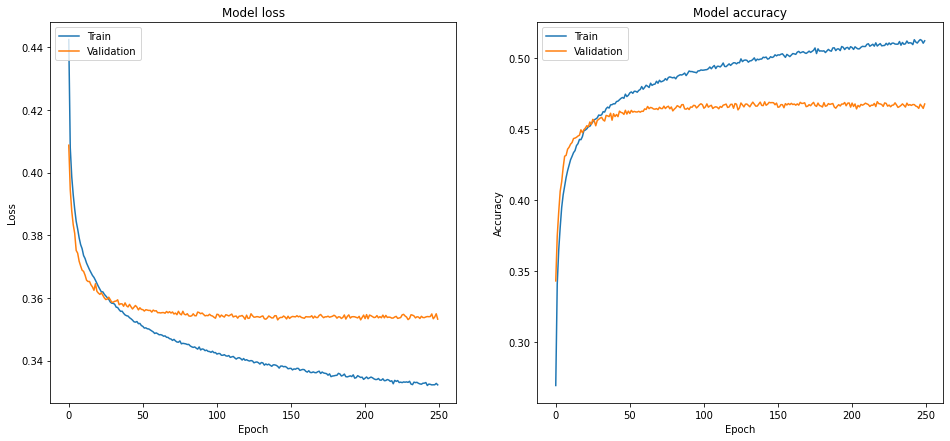

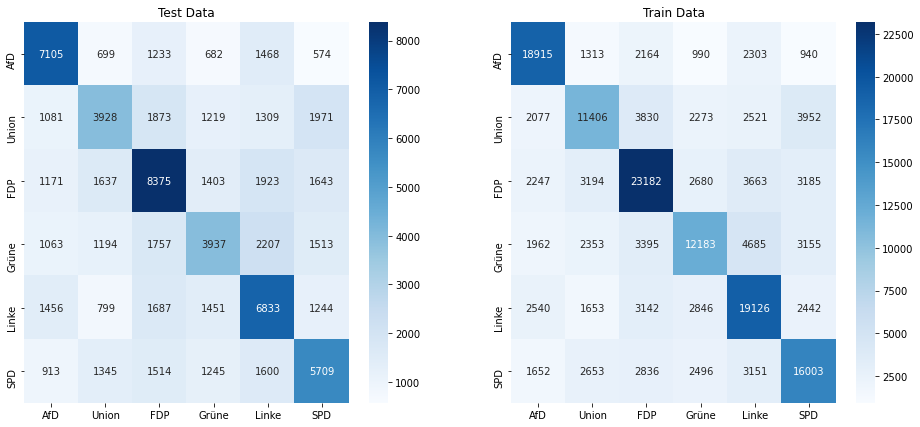

Party: 	 Test 	 Train
Afd:	 11761 	 26625
Union:	 11381 	 26059
FDP:	 16152 	 38151
Grüne:	 11671 	 27733
Linke:	 13470 	 31749
SPD:	 12326 	 28791

Acc:	 46.75% 56.29%


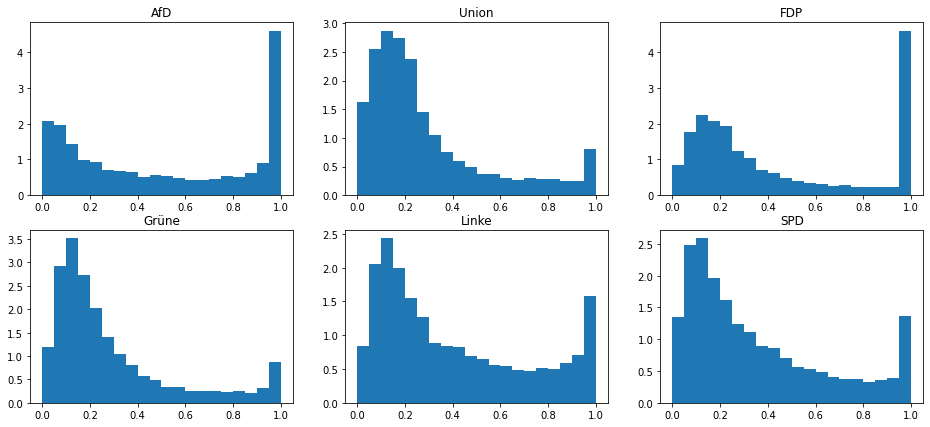

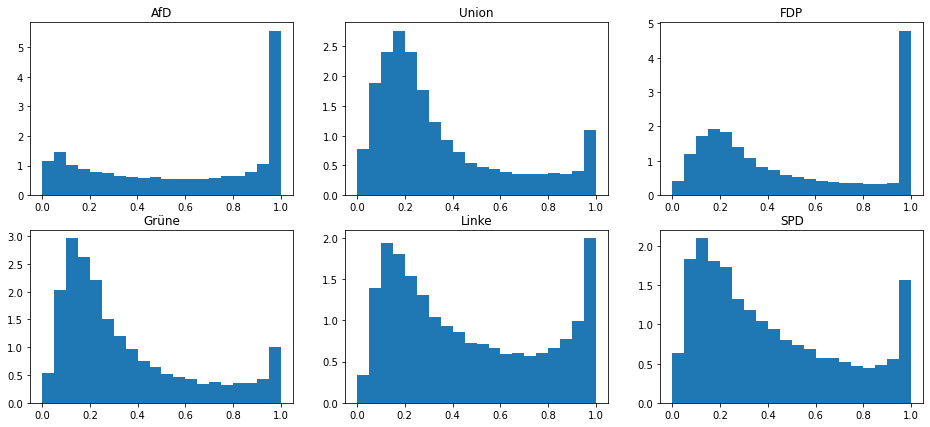

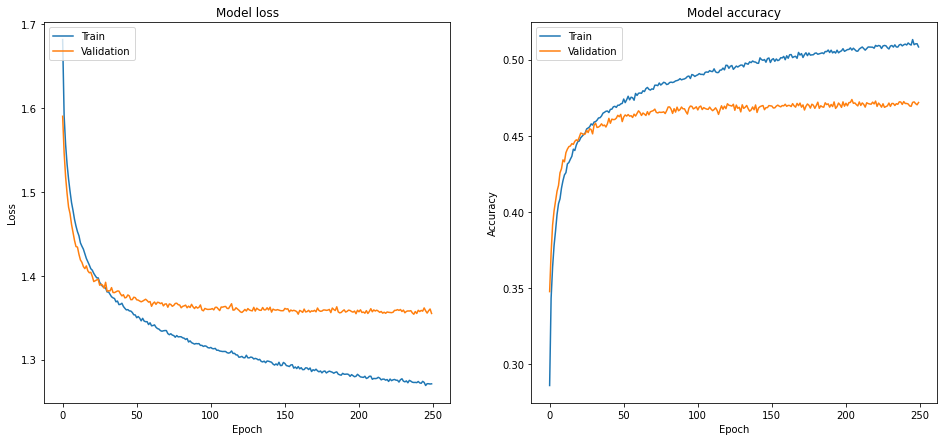

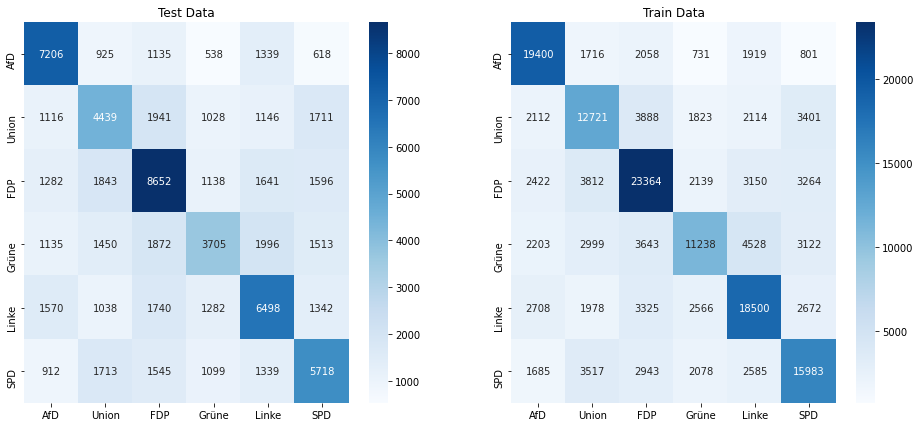

Party: 	 Test 	 Train
Afd:	 11761 	 26625
Union:	 11381 	 26059
FDP:	 16152 	 38151
Grüne:	 11671 	 27733
Linke:	 13470 	 31749
SPD:	 12326 	 28791

Acc:	 47.18% 56.51%


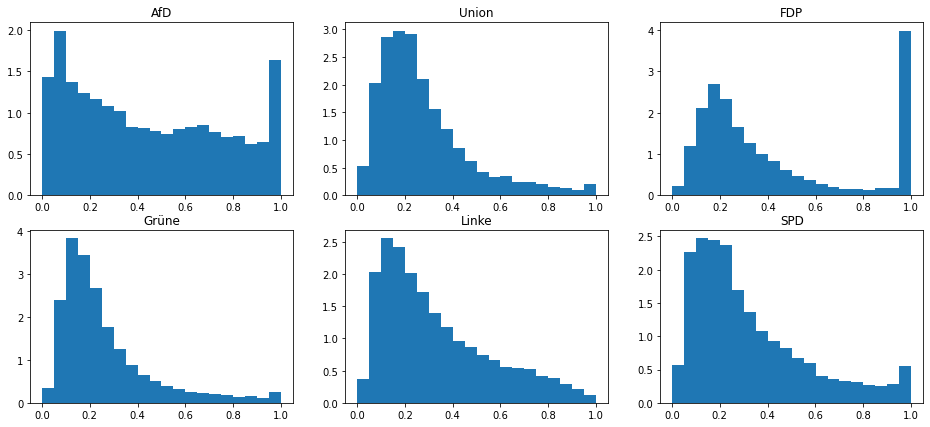

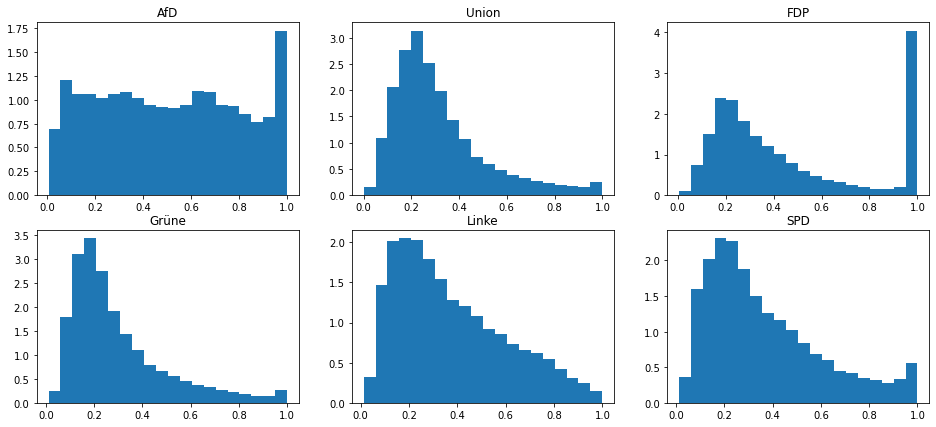

In [273]:
vis_hist(hist1)
vis_confusion_mat(model1, X_test, X_train, y_test, y_train)
vis_classification_distribution(model1, X_test, y_test)
vis_classification_distribution(model1, X_train, y_train)

vis_hist(hist2)
vis_confusion_mat(model2, X_test, X_train, y_test, y_train)
vis_classification_distribution(model2, X_test, y_test)
vis_classification_distribution(model2, X_train, y_train)

In [401]:
def export_model(model, name):
    result = []
    for layer in model.layers:
        if type(layer) == Dense:
            weights = layer.get_weights()[0]
            bias = layer.get_weights()[1]
            result.append({'weights': weights.tolist(), 'bias': bias.tolist()})
    with open(name+'.txt', 'w') as outfile:
        json.dump(result, outfile)

In [402]:
import json
export_model(model1, 'model')

In [413]:
import spacy
nlp = spacy.load("de_core_news_lg", exclude=['tagger', 'morphologizer', 'parser', 'senter', 'ner', 'attribute_ruler', 'lemmatizer'])
def build_model(file):
    W = []
    B = []
    with open(file) as json_file:
        data = json.load(json_file)
        for layer in data:
            W.append(np.array(layer['weights']))
            B.append(np.array(layer['bias']))
    return W, B

def predict_vector(vector, W, B):
    for i in range(len(W) - 1):
        vector = np.maximum(0,np.matmul(vector,W[i]) + B[i])
    vector = np.matmul(vector,W[len(W) - 1]) + B[len(W) - 1]
    return np.exp(vector)/np.sum(np.exp(vector))

def predict_tweet(tweet, model_path):
    W, B = build_model(model_path)
    return predict_vector(nlp(tweet).vector, W, B)

In [419]:
predict_tweet('Hey wir sollten es mal mehr gegen den Klimawandel machen', 'model.txt')

array([0.38978638, 0.0960164 , 0.12494855, 0.14843836, 0.11078286,
       0.13002745])

In [420]:
model2.predict([[0]*300, nlp('Hey wir sollten es mal mehr gegen den Klimawandel machen').vector])

array([[0.2697895 , 0.02891691, 0.05087465, 0.11179136, 0.50040436,
        0.03822317],
       [0.13453673, 0.09720228, 0.12101834, 0.35427427, 0.19437808,
        0.09859037]], dtype=float32)

In [229]:
def loss_function1(y_actual, y_predict):
    return K.sum((y_actual - y_predict)**2)

def loss_function2(y_actual, y_predict):
    temp = y_actual - y_predict
    print(temp.eval(session = tf.Session()))
    return K.sum(K.abs(temp))

In [241]:
def vis_hist(hist):
    fig, axes = plt.subplots(1, 2, figsize=(16,7))
    a = axes.ravel()
    a[0].plot(hist.history['loss'])
    a[0].plot(hist.history['val_loss'])
    a[0].set_title('Model loss')
    a[0].set_ylabel('Loss')
    a[0].set_xlabel('Epoch')
    a[0].legend(['Train', 'Validation'], loc='upper left')
    a[1].plot(hist.history['accuracy'])
    a[1].plot(hist.history['val_accuracy'])
    a[1].set_title('Model accuracy')
    a[1].set_ylabel('Accuracy')
    a[1].set_xlabel('Epoch')
    a[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def vis_confusion_mat(model, X_test, X_train, y_test, y_train):
    fig, axes = plt.subplots(1, 2, figsize=(16,7))
    # Block to evaluate training data
    yhat_test_prop = model.predict(X_test)
    yhat_test = np.argmax(yhat_test_prop, axis=1)

    y_label_test = np.argmax(y_test, axis=1)

    mat = confusion_matrix(y_label_test, yhat_test)
    df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                      columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
    # ax1.figure(figsize = (7,5))
    sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');
    # ax1.show()

    # Block to evaluate test data
    yhat_train_prop = model.predict(X_train)
    yhat_train = np.argmax(yhat_train_prop, axis=1)

    y_label_train = np.argmax(y_train, axis=1)

    mat = confusion_matrix(y_label_train, yhat_train)
    df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                      columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
    # ax2.figure(figsize = (7,5))
    sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
    plt.show()
    print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
    print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
    print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
    print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
    print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
    print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
    print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))
    
def vis_classification_distribution(model, X_test, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(16,7))
    a = axes.ravel()
    
    yhat_test_prop = model.predict(X_test)
    y_label_test = np.argmax(y_test, axis=1)

    party_probs = [[], [], [], [], [], []]
    for ind,val in enumerate(yhat_test_prop):
        party = y_label_test[ind]
        party_probs[party].append(val[party])

    labels = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"]
    for i,j in enumerate(party_probs):
        a[i].hist(j, bins=20, density=True)
        a[i].set_title(labels[i])
    plt.show()